# GPT-2 
---

In [1]:
import tensorflow as tf

In [2]:
tf.enable_eager_execution()

---
## Attention mask

In [56]:
def attention_mask(nd, ns, *, dtype):
    """
    1's in the lower triangle, counting from the lower right corner.

    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

nd is vertical/external  
ns is horizontal/internal

In [4]:
attention_mask(4, 5, dtype=tf.float32)

<tf.Tensor: id=18, shape=(4, 5), dtype=float32, numpy=
array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [5]:
attention_mask(14, 5, dtype=tf.float32)

<tf.Tensor: id=37, shape=(14, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [6]:
attention_mask(4, 9, dtype=tf.float32)

<tf.Tensor: id=56, shape=(4, 9), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [7]:
attention_mask(9, 9, dtype=tf.float32)

<tf.Tensor: id=75, shape=(9, 9), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

--- 

### Tech deets

It is possible to use `None` in a slice as an equivalent for [tf.newaxis](https://www.tensorflow.org/api_docs/python/tf/Tensor#__getitem__) (scroll down a little), cf. also [this on the Stack](https://stackoverflow.com/a/44787333).

In [34]:
nd = 5 # vertical/external
print(tf.range(nd).numpy())

[0 1 2 3 4]


In [35]:
i = tf.range(nd)[:, None] # None same as tf.newaxis
print(i.numpy()) # Now has a new dimension added innermostly

[[0]
 [1]
 [2]
 [3]
 [4]]


In [36]:
i2 = tf.range(nd)[None, :]
print(i2.numpy()) # Instead a new external dimension

[[0 1 2 3 4]]


In [32]:
ns = 8 # horizontal/internal
j = tf.range(ns)
print(j.numpy())

[0 1 2 3 4 5 6 7]


'Shift' to the left, so the rightmost element of j is just equal to the highest dimension of i (which means: `j - ns`, everything shifted to negative numbers, `+ nd`, we go back up to have `nd` numbers above zero). 

In [37]:
print(i.numpy())
print((j - ns).numpy()) 
print((j - ns + nd).numpy()) 

[[0]
 [1]
 [2]
 [3]
 [4]]
[-8 -7 -6 -5 -4 -3 -2 -1]
[-3 -2 -1  0  1  2  3  4]


In [27]:
i >= j - ns + nd

<tf.Tensor: id=296, shape=(5, 8), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True]])>

Clever use of the comparison operator, which will use numpy broadcasting, so that the 'vertical' vector i will be compared elementwise to the 'horizontal' one j, leading to a `i x j` matrix filled with `True/False` values, that can then be cast as 1s & 0s in the last step.

In [38]:
m = (i >= j - ns + nd)
m

<tf.Tensor: id=366, shape=(5, 8), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True]])>

---
## In TF

The [tf function](https://www.tensorflow.org/api_docs/python/tf/linalg/band_part) mentioned, described as "Copy a tensor setting everything outside a central band in each innermost matrix to zero":

In [3]:
nd, ns = 4, 8
ones = tf.ones([nd, ns])
tf.matrix_band_part(ones, -1, ns-nd)

<tf.Tensor: id=6, shape=(4, 8), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

Not in fact identical to the implemented function if nd > ns!

In [4]:
nd, ns = 8, 4
ones = tf.ones([nd, ns])
tf.matrix_band_part(ones, -1, ns-nd)

<tf.Tensor: id=13, shape=(8, 4), dtype=float32, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>

Examples from the tf doc:

In [32]:
ones = tf.ones([5,5])
print(tf.matrix_band_part(ones, 0, -1).numpy(), end='\n\n') # ==> Upper triangular part.
print(tf.matrix_band_part(ones, -1, 0).numpy(), end='\n\n') # ==> Lower triangular part
print(tf.matrix_band_part(ones, 0, 0).numpy(), end='\n\n') # ==> Diagonal.

[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]



Upper triangle:

In [53]:
print(tf.matrix_band_part(ones,0,-1).numpy(), end='\n\n') # -1 stands for 'all diagonals'
print(tf.matrix_band_part(ones,0,4).numpy(), end='\n\n')  # same result
print(tf.matrix_band_part(ones,0,3).numpy(), end='\n\n')  # gradual reduction until 
print(tf.matrix_band_part(ones,0,2).numpy(), end='\n\n')  # only the core diagonal 
print(tf.matrix_band_part(ones,0,1).numpy(), end='\n\n')  # is left
print(tf.matrix_band_part(ones,0,0).numpy(), end='\n\n')

[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]



Lower triangle:

In [54]:
print(tf.matrix_band_part(ones,0,0).numpy(), end='\n\n') # this time going downward
print(tf.matrix_band_part(ones,1,0).numpy(), end='\n\n')
print(tf.matrix_band_part(ones,2,0).numpy(), end='\n\n')
print(tf.matrix_band_part(ones,3,0).numpy(), end='\n\n')
print(tf.matrix_band_part(ones,4,0).numpy(), end='\n\n')
print(tf.matrix_band_part(ones,-1,0).numpy(), end='\n\n')

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]



Interestingly, not quite the desired result either if nd > ns: the reference point is the **upper left corner** (and diagonal from there), instead of the bottom right one.

In [26]:
ones = tf.ones([8,5])
print(tf.matrix_band_part(ones, 0, -1).numpy(), end='\n\n') # ==> Upper triangular part.
print(tf.matrix_band_part(ones, -1, 0).numpy(), end='\n\n') # ==> Lower triangular part
print(tf.matrix_band_part(ones, 0, 0).numpy(), end='\n\n') # ==> Diagonal.

[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



---

### Numpy Triu

Used in the [Transformer architecture](http://nlp.seas.harvard.edu/2018/04/03/attention.html#decoder) (see below under `subsequent_mask`). 

Documentation:
- [Triu](https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu.html?highlight=triu#numpy.triu) (zeroes below diag <> upper right triangle);
- [Tril](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tril.html#numpy.tril) (zeroes above diag <> lower left triangle).

The calculation is the same as above, from the top left corner (not the bottom right one, like in the current implementation).

In [3]:
import numpy as np

In [20]:
nd, ns = 4, 8
triu_ones = tf.ones([nd, ns])
print(np.triu(triu_ones, 0), end='\n\n') # zeroes below diagonal
print(np.tril(triu_ones, 0), end='\n\n') # zeroes above diagonal

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1.]]

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]]



In [21]:
nd, ns = 8, 4
triu_ones = tf.ones([nd, ns])
print(np.triu(triu_ones, 0), end='\n\n') # zeroes below diagonal
print(np.tril(triu_ones, 0), end='\n\n') # zeroes above diagonal

[[1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[[1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]



The int parameter allows one to control how many diagonals are zeroed out.

In [23]:
nd, ns = 5, 5
triu_ones = tf.ones([nd, ns])
print(np.triu(triu_ones, 0), end='\n\n')  # main diagonal (from top left)
print(np.triu(triu_ones, -1), end='\n\n') # one more diagonal, going down
print(np.triu(triu_ones, 1), end='\n\n') # one less diagonal, going up

[[1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]]

[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]



Opposite function with tril: zeroes above diag, lower left triangle.

In [25]:
nd, ns = 5, 5
triu_ones = tf.ones([nd, ns])
print(np.tril(triu_ones, 0), end='\n\n')  # main diagonal (from top left)
print(np.tril(triu_ones, -1), end='\n\n') # one less diagonal, going down
print(np.tril(triu_ones, 1), end='\n\n') # one more diagonal, going up

[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]]

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]]

[[1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]



---

## Plotting it

Plot taken from [this page](http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention) (scroll up).

In [82]:
import matplotlib.pyplot as plt

In [104]:
print(np.tril(tf.ones([20,20]), 0))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.

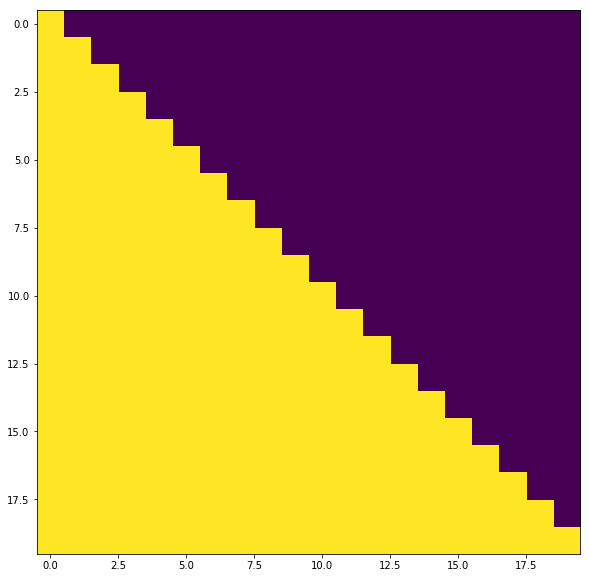

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(np.tril(tf.ones([20,20]), 0))

---
### Performance tests

Tensorflow wins again!

In [55]:
nd, ns = 5, 5

In [76]:
%%timeit

attention_mask(nd, ns, dtype=tf.float32)

238 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [74]:
%%timeit

ones = tf.ones([nd, ns])
tf.matrix_band_part(ones, -1, ns-nd)

77.1 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [75]:
%%timeit 

ones = tf.ones([nd, ns])
np.tril(ones, 0)

104 µs ± 3.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
